# COVID-19 Integration with PBMC and HCL atlases

In this notebook, we are going to integrate COVID19 with PBMC and HCL atlases with scArches' pipeline. 

First, we load all datasets and separate query and reference datasets. Next, we train a network PBMC and HCL datasets (17 reference datasets). Then, we will perform architecture surgery and add 1 more condition to the network (1 query condition). In the next step, we will fine-tune the new scArches network on COVID-19 dataset which we call them query dataset. Finally, we visualize Z-latent projection of all integrated datasets. 

In general, scArches' pipeline consists of the following steps:

1. Load the query & reference datasets and seperate query from reference.
2. Train scArches with reference datasets
    - Qualitatively evaluate trained scArches with Z space reference projection UMAPs
3. Perform architecture surgery and add query conditions 
4. Train new scArches network (which has much less trainable parameters) on query datasets
    - Qualitatively evaluate trained scArches with Z space query projection UMAPs
    - Qualitatively evaluate trained scArches with Z space query&reference projection UMAPs

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.chdir("/home/mohsen/projects/scarches/")

In [2]:
import scarches as sca
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')

Using TensorFlow backend.


In [3]:
condition_key = "study"
cell_type_key = 'celltype'
target_conditions = ["COVID-19 (query)"]

## Loading data

In [4]:
adata = sca.data.read("/home/mohsen/data/covid_lisa/covid_for_publish_normalized_5k.h5ad")
adata

AnnData object with n_obs × n_vars = 274346 × 5000 
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue'
    var: 'n_cells-0', 'n_cells-0-0-1', 'gene_ids-1-0-1', 'feature_types-1-0-1', 'genome-1-0-1'

## Now we separate query(target) and reference(source) datasets

In [5]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 211877 × 5000 
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue'
    var: 'n_cells-0', 'n_cells-0-0-1', 'gene_ids-1-0-1', 'feature_types-1-0-1', 'genome-1-0-1'

In [6]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 62469 × 5000 
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue'
    var: 'n_cells-0', 'n_cells-0-0-1', 'gene_ids-1-0-1', 'feature_types-1-0-1', 'genome-1-0-1'

## Calculate number of studies (batches)

In [7]:
source_conditions = source_adata.obs[condition_key].unique().tolist()

## Create an instance of scArches model

In [8]:
network = sca.models.scArches(task_name='covid_reference',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 128],
                              size_factor_key='size_factors',
                              gene_names=adata.var_names.tolist(),
                              conditions=source_conditions,
                              lr=0.001,
                              alpha=0.0002,
                              device='gpu',
                              use_batchnorm=True,
                              loss_fn='nb',
                              model_path="./models/scArches/",
                              dropout_rate=0.1,
                              )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
scArchesNB's network has been successfully constructed!
scArchesNB's network has been successfully compiled!


## Train scArches

You can train scArches with `train` function with the following parameters:

1. __adata__: Annotated dataset used for training and evaluating scArches.
2. __train_size__: Fraction of adata used for training. The rest will be used for validation.
3. __condition_key__: name of the column in `obs` matrix in `adata` which contains the conditions for each sample.
4. __n_epochs__: number of epochs used to train scArches.
5. __batch_size__: number of sample used to sample as mini-batches in order to optmize scArches. 
6. __save__: whether to save scArches' model and configs after training phase or not. 
7. __retrain__: if `False` and scArches' pretrained model exists in `model_path`, will restore scArches' weights. Otherwise will train and validate scArches on `adata`. 

In [9]:
network.train(source_adata,
              train_size=0.9,
              condition_key=condition_key,
              n_epochs=200,
              batch_size=128,
              early_stop_limit=10,
              save=True,
              )

Instructions for updating:
Use tf.cast instead.
 |████████████████████| 100.0%  - loss: 0.2780 - kl: 4.5533 - nb: 0.2771 - val_loss: 0.2710 - val_kl: 4.4047 - val_nb: 0.2701

scArchesNB has been successfully saved in ./models/scArches/covid_reference.


## Get latent output for the reference dataset

Latent space representation of reference data can be computed using `get_latent` function
This function has the following parameters:

1. __adata__: Annotated dataset to be transformed to latent space
2. __condition_key__: Name of the column in `obs` matrix in `adata` which contains the study for each sample.


In [10]:
latent_adata = network.get_latent(source_adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 211877 × 10 
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue'

## UMAP visualization of reference latent with Scanpy

In [11]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

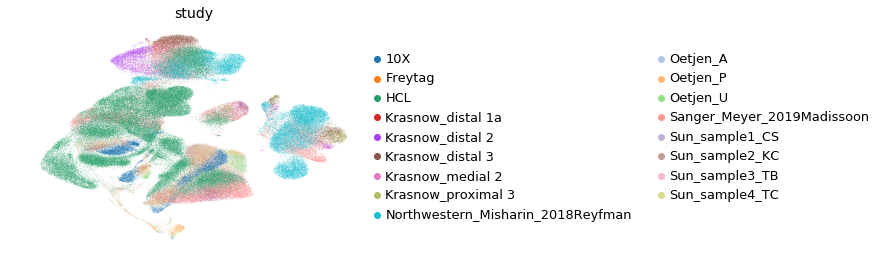

In [12]:
sc.pl.umap(latent_adata, color=[condition_key], 
           frameon=False, wspace=0.6)

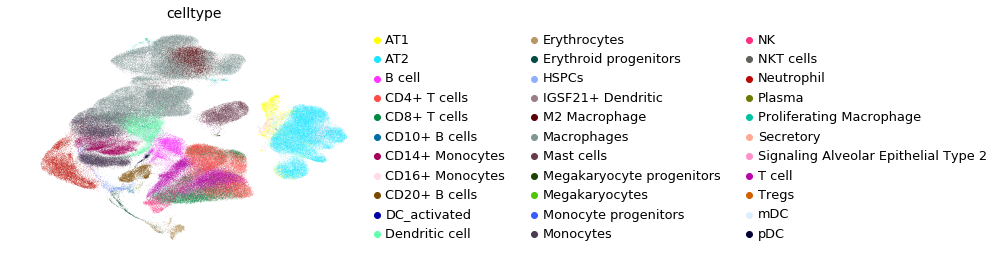

In [13]:
sc.pl.umap(latent_adata, color=[cell_type_key], 
           frameon=False, wspace=0.6)

## architecture Surgery (scArches v1)
In order to perform Architecture surgery on pre-trained scArches model, `operate` function is available with the following arguments:

1. __network__: pre-trained scArches object.
2. __new_task_name__: name of the task you want to solve (related to query atlas you have)
3. __new_conditions__: list of (unique) new studies.
4. __version__: version of scArches you want to use. Must be one of "scArches", "scArches v1", or "scArches v2".

In [14]:
new_network = sca.operate(network,
                          new_task_name="covid_query",
                          new_conditions=target_conditions,
                          version='scArches v1',
                          )

scArchesNB's network has been successfully constructed!
scArchesNB's network has been successfully compiled!
scArchesNB's network has been successfully compiled!


## Train with query datasets

In [15]:
new_network.train(target_adata,
                  condition_key=condition_key,
                  n_epochs=100,
                  batch_size=128, 
                  save=True,
                 )

 |████████████████████| 100.0%  - loss: 0.0210 - kl_loss: 0.2083 - recon_loss: 0.0209 - val_loss: 0.4499 - val_kl_loss: 4.4399 - val_recon_loss: 0.4490

scArchesNB has been successfully saved in ./models/scArches/covid_query.


## Project query+reference data in to the latent space

In [19]:
latent_adata = new_network.get_latent(adata, condition_key)

In [20]:
sc.pp.subsample(latent_adata, n_obs=50000)

In [21]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

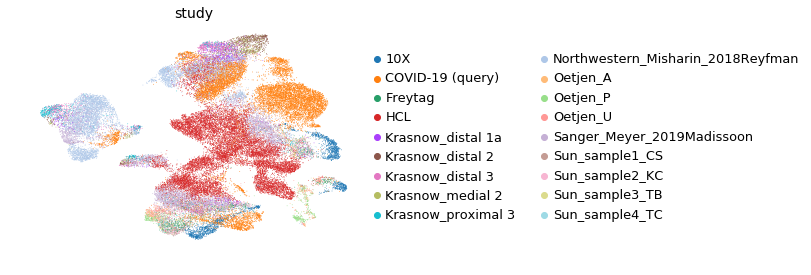

In [24]:
sc.pl.umap(latent_adata, color=[condition_key], 
           wspace=0.5, frameon=False)

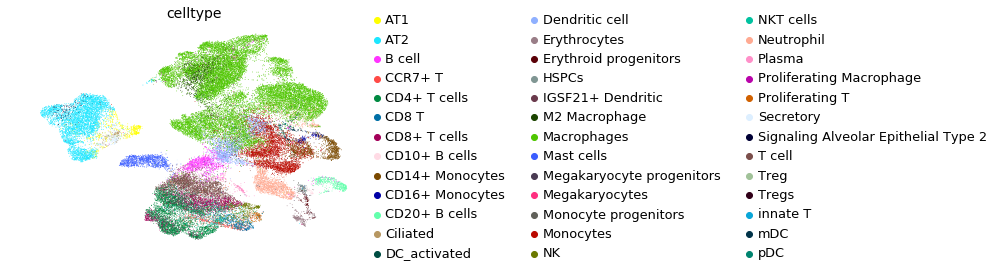

In [23]:
sc.pl.umap(latent_adata, color=[cell_type_key], 
           wspace=0.5, frameon=False)

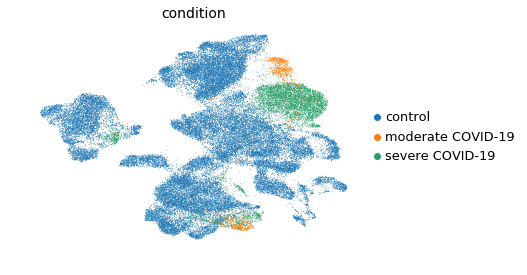

In [25]:
sc.pl.umap(latent_adata, color=["condition"], 
           wspace=0.5, frameon=False)